# Workshop 5. Рекомендательная система

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [66]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [68]:
anime = pd.read_csv('data/anime/anime.csv', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [69]:
ratings = pd.read_csv('data/anime/rating.csv.zip')
ratings.head(10)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


## Обзор данных

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

## Жанры

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

In [70]:
movie_anime = anime[anime["type"] == "Movie"]



from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = movie_anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))


Genres=['Supernatural', 'Music', 'Martial Arts', 'Psychological', 'Adventure', 'Cars', 'Seinen', 'Samurai', 'Horror', 'Comedy', 'Dementia', 'Shoujo', 'Shounen', 'Military', 'Mystery', 'Vampire', 'Sports', 'Ecchi', 'Mecha', 'Harem', 'Drama', 'Shounen Ai', 'Magic', 'Action', 'Historical', 'Space', 'Demons', 'Josei', 'Game', 'Fantasy', 'Slice of Life', 'Romance', 'Super Power', 'Police', 'Hentai', 'Thriller', 'Kids', 'Sci-Fi', 'School', 'Parody']
len=40


In [71]:
pd_movie_anime = pd.DataFrame(index=movie_anime.index)

for g in genres:
    pd_movie_anime[g] = movie_anime['genre'].str.contains(g).astype(int)

In [72]:
pd_movie_anime.head(30)

pd_movie_anime.set_index(movie_anime["name"])


,Supernatural,Music,Martial Arts,Psychological,Adventure,Cars,Seinen,Samurai,Horror,Comedy,...,Slice of Life,Romance,Super Power,Police,Hentai,Thriller,Kids,Sci-Fi,School,Parody
name,,,,,,,,,,,,,,,,,,,,,
Kimi no Na wa.,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
Koe no Katachi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Sen to Chihiro no Kamikakushi,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ookami Kodomo no Ame to Yuki,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Mononoke Hime,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Suzumiya Haruhi no Shoushitsu,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
Mushishi Zoku Shou: Suzu no Shizuku,1,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Howl no Ugoku Shiro,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


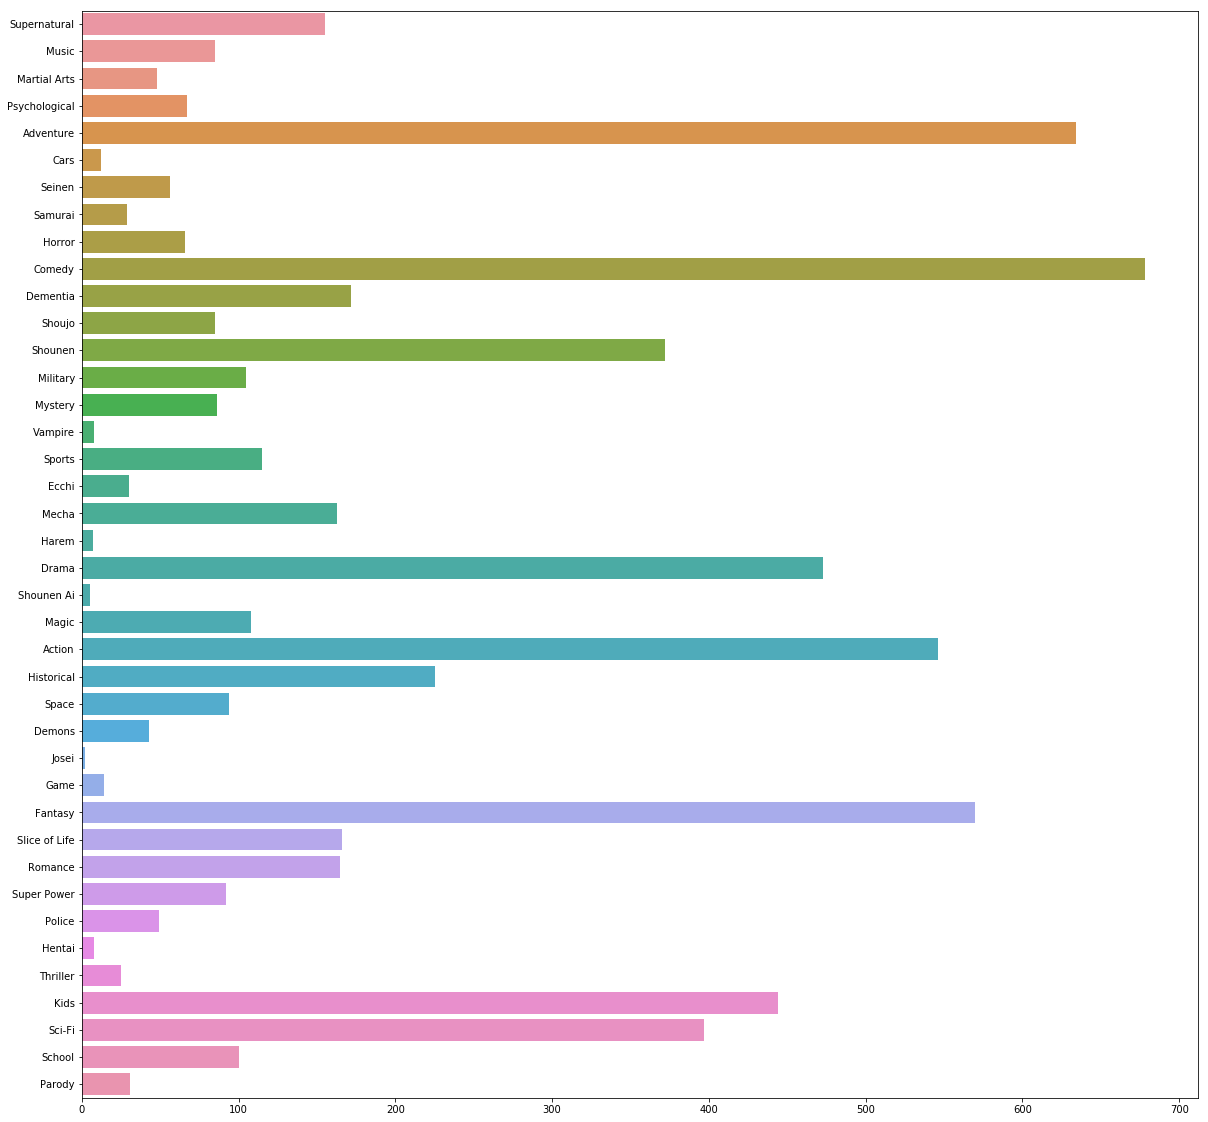

In [73]:
plt.figure(figsize=(20,20))
sns.barplot(x=pd_movie_anime.sum(),y=genres)


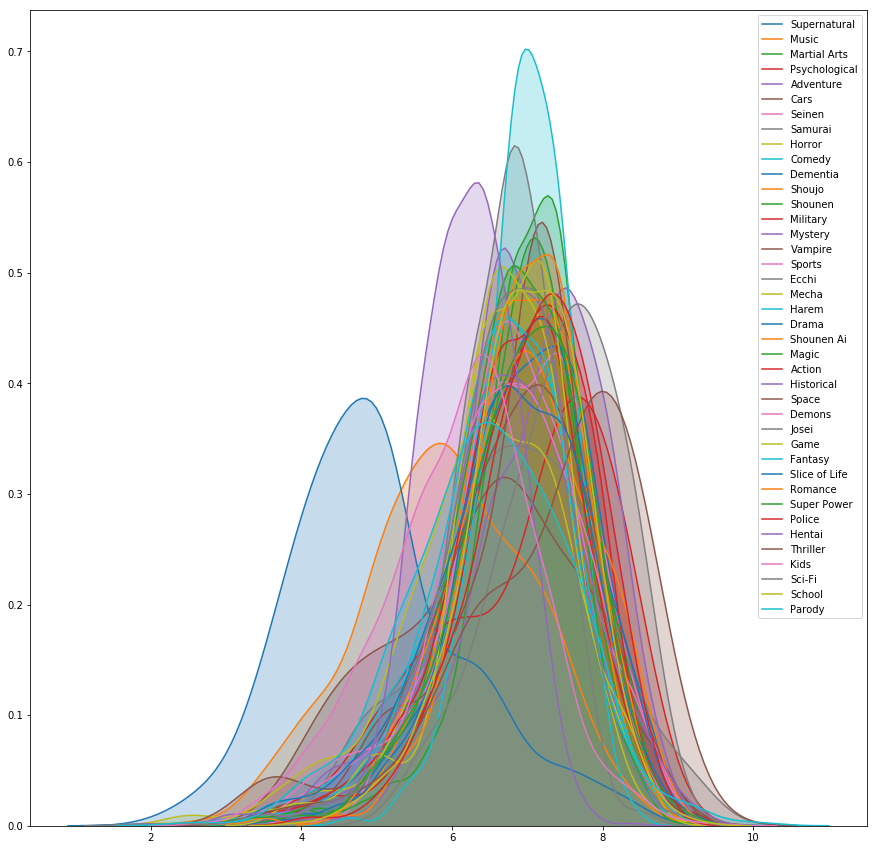

In [74]:
fig, ax = plt.subplots(figsize=(15,15))
for g in genres:
    sns.kdeplot(anime[anime['genre'].str.contains(g)]['rating'], shade=True, label=g, ax=ax)

## Рейтинг

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

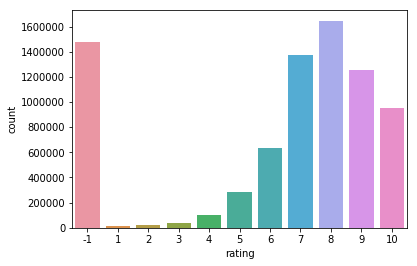

In [75]:
sns.countplot(x="rating", data=ratings)

## Фильтрация данных

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [76]:
a = ratings.groupby('anime_id').count()['rating']
anime_watches = pd.DataFrame(a)
anime_ratings = anime.join(anime_watches, rsuffix='_sum')
anime_ratings.head()





,name,genre,type,episodes,rating,members,rating_sum
anime_id,,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,2199.0
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,24574.0
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,1386.0
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,19283.0
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,3673.0


In [77]:
a = ratings.groupby('user_id').count()["rating"]

user_raiting = ratings.join(a,on='user_id',rsuffix='_count')
user_raiting.head()
a = user_raiting.join(anime_ratings,on = 'anime_id',rsuffix='_mean')
print(a['rating_count'].median())
a[a['user_id']==2]

217.0


,user_id,anime_id,rating,rating_count,name,genre,type,episodes,rating_mean,members,rating_sum
153,2,11771,10,3,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315.0,11522.0
154,2,12189,-1,3,Hyouka,"Mystery, School, Slice of Life",TV,22,8.17,372246.0,10523.0
155,2,16417,-1,3,Tamako Market,"Comedy, Slice of Life",TV,12,7.35,128529.0,3891.0


In [78]:
anime_ratings = a[a['rating_sum']> a['rating_sum'].median()][a['rating_count']> a['rating_count'].median()]


/home/demon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [79]:
anime_ratings.shape

(1567761, 11)

In [80]:

anime_ratings.rating[a.rating==-1]=anime_ratings.rating_mean[a.rating==-1]
anime_ratings['name'].value_counts
anime_ratings.values

array([[5, 6, 8.0, ..., 8.32, 283069.0, 11077.0],
       [5, 20, 6.0, ..., 7.81, 683297.0, 25925.0],
       [5, 24, 1.0, ..., 8.06, 178553.0, 7153.0],
       ...,
       [73507, 8074, 10.0, ..., 7.46, 535892.0, 23065.0],
       [73507, 8769, 8.0, ..., 7.49, 321477.0, 13825.0],
       [73507, 10067, 5.0, ..., 7.63, 134180.0, 7032.0]], dtype=object)

In [81]:
anime_ratings

,user_id,anime_id,rating,rating_count,name,genre,type,episodes,rating_mean,members,rating_sum
302,5,6,8.0,467,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069.0,11077.0
306,5,20,6.0,467,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,25925.0
308,5,24,1.0,467,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0,7153.0
309,5,30,1.0,467,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,26,8.32,461946.0,17686.0
310,5,45,7.0,467,Rurouni Kenshin: Meiji Kenkaku Romantan,"Action, Adventure, Comedy, Historical, Romance...",TV,94,8.43,218928.0,7900.0
311,5,47,8.0,467,Akira,"Action, Adventure, Horror, Military, Sci-Fi, S...",Movie,1,8.15,215897.0,9748.0
312,5,57,7.0,467,Beck,"Comedy, Drama, Music, Shounen, Slice of Life",TV,26,8.40,148328.0,5749.0
313,5,63,1.0,467,DearS,"Comedy, Ecchi, Harem, Romance, Sci-Fi",TV,12,6.80,91037.0,4978.0
315,5,68,6.0,467,Black Cat,"Adventure, Comedy, Sci-Fi, Shounen, Super Power",TV,23,7.52,150512.0,6072.0
317,5,136,8.0,467,Hunter x Hunter,"Action, Adventure, Shounen, Super Power",TV,62,8.48,166255.0,5626.0


## Матрица user-item

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [82]:
pd_anime_ratings = anime_ratings.pivot_table(values='rating', index='user_id', columns='name')

In [83]:
pd_anime_ratings



name,.hack//Sign,07-Ghost,11eyes,Aa! Megami-sama! (TV),Absolute Duo,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!,...,Yu☆Gi☆Oh! Duel Monsters,Zankyou no Terror,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetsuen no Tempest,Zoku Natsume Yuujinchou,ef: A Tale of Memories.,xxxHOLiC
user_id,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,2.00,3.00,NaN,NaN,NaN,4.00,...,3.00,NaN,1.00,1.00,1.00,1.0,NaN,NaN,NaN,2.00
7,NaN,NaN,NaN,NaN,8.00,8.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,...,NaN,7.00,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
38,NaN,NaN,1.00,NaN,NaN,8.00,NaN,NaN,NaN,5.00,...,NaN,9.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,9.00,NaN,7.00,8.00,7.00,NaN,8.00,9.00,...,NaN,NaN,6.00,NaN,6.00,NaN,8.00,NaN,NaN,7.00
46,NaN,8.00,3.00,NaN,NaN,NaN,NaN,NaN,9.00,9.00,...,NaN,10.00,NaN,NaN,NaN,NaN,9.00,10.00,NaN,NaN
54,NaN,NaN,6.49,7.45,NaN,7.62,NaN,NaN,7.69,7.84,...,NaN,8.26,7.62,7.77,7.73,7.6,NaN,8.64,NaN,NaN
123,NaN,7.00,NaN,NaN,NaN,7.00,NaN,NaN,NaN,7.00,...,NaN,9.00,NaN,NaN,NaN,NaN,8.00,10.00,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,9.00,8.00,NaN,9.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
pd_anime_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9909 entries, 5 to 73507
Columns: 457 entries, .hack//Sign to xxxHOLiC
dtypes: float64(457)
memory usage: 34.6 MB


In [85]:
pd_anime_ratings = pd_anime_ratings.fillna(0)


In [86]:
pd_anime_ratings

name,.hack//Sign,07-Ghost,11eyes,Aa! Megami-sama! (TV),Absolute Duo,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!,...,Yu☆Gi☆Oh! Duel Monsters,Zankyou no Terror,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetsuen no Tempest,Zoku Natsume Yuujinchou,ef: A Tale of Memories.,xxxHOLiC
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.00,0.00,0.00,0.00,2.00,3.00,0.00,0.00,0.00,4.00,...,3.00,0.00,1.00,1.00,1.00,1.0,0.00,0.00,0.00,2.00
7,0.00,0.00,0.00,0.00,8.00,8.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,...,0.00,7.00,0.00,0.00,0.00,0.0,0.00,0.00,8.00,0.00
38,0.00,0.00,1.00,0.00,0.00,8.00,0.00,0.00,0.00,5.00,...,0.00,9.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
43,0.00,0.00,9.00,0.00,7.00,8.00,7.00,0.00,8.00,9.00,...,0.00,0.00,6.00,0.00,6.00,0.0,8.00,0.00,0.00,7.00
46,0.00,8.00,3.00,0.00,0.00,0.00,0.00,0.00,9.00,9.00,...,0.00,10.00,0.00,0.00,0.00,0.0,9.00,10.00,0.00,0.00
54,0.00,0.00,6.49,7.45,0.00,7.62,0.00,0.00,7.69,7.84,...,0.00,8.26,7.62,7.77,7.73,7.6,0.00,8.64,0.00,0.00
123,0.00,7.00,0.00,0.00,0.00,7.00,0.00,0.00,0.00,7.00,...,0.00,9.00,0.00,0.00,0.00,0.0,8.00,10.00,0.00,0.00
129,0.00,0.00,0.00,0.00,0.00,9.00,8.00,0.00,9.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00


In [87]:
pd_anime_ratings.values

array([[ 0.,  0.,  0., ...,  0.,  0.,  2.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  8.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., 10., 10.],
       [ 0.,  0.,  0., ...,  7.,  0.,  8.],
       [ 0.,  0.,  3., ...,  0.,  0., 10.]])

## Понижение размерности

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

In [88]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=4)
df_pca = pca.fit_transform(pd_anime_ratings)

df_pca

array([[ -7.04410787, -22.55068994,  -0.69564045,  -3.01277197],
       [  3.67926934, -20.26254564, -13.3936344 , -18.73134936],
       [ 19.74921149,  -2.66267472,  39.02335874, -18.45711335],
       ...,
       [ 18.59226585,  41.04017133, -10.20267135, -36.47241048],
       [-17.21938298,  -7.06718368,  19.04249784,   7.82429632],
       [-36.50926606,  23.2685761 ,  -4.98396585,  -8.74567951]])

## Обучение kNN

Обучим kNN, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kNN
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

In [89]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=17)
clf.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [90]:
clf.cluster_centers_

array([[ 18.49645113,  14.3696181 , -18.87432133,  -8.77275685],
       [-36.12312784,  11.9291577 ,  -8.49967354,   6.1035954 ],
       [ -1.58159927,  -8.94564832,  -4.48040565, -18.18271819],
       [ 48.04089289,   2.47252303,  -9.1238162 ,   7.35341353],
       [ -3.29192202, -12.14892673,  21.81614086,  -7.56526853],
       [ 31.78810259,  -7.35954675,   9.88601516,  -9.22322599],
       [ -9.811012  ,  36.69545017,  -7.37646595,   0.08510111],
       [  7.2407238 ,  20.24217563,  20.15306953, -12.7058745 ],
       [-24.93777655,   9.45410279,  11.91915343,  -9.28896283],
       [ 39.66234656,  36.32529426,   7.49802779,   9.39124735],
       [  5.05889162,  -2.35665426, -12.07743257,  19.73046349],
       [-12.84221112,   6.60090324, -25.80593082,  -0.91915928],
       [ 15.25489272, -25.60956111,   5.58805671,   6.71226287],
       [  3.6243026 ,   7.22679074,  21.81254068,  16.07118007],
       [-16.0657553 , -16.39599066,   7.81968635,  14.11486009],
       [-37.91766005, -11

In [91]:
clf.cluster_centers_.shape

(17, 4)

## Top 15 аниме

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

In [92]:
import numpy as np

In [93]:
pd_anime_ratings["claster"] = clf.predict(df_pca)
a = pd_anime_ratings.groupby('claster').mean()
a.head()

name,.hack//Sign,07-Ghost,11eyes,Aa! Megami-sama! (TV),Absolute Duo,Accel World,Afro Samurai,Air,Air Gear,Akame ga Kill!,...,Yu☆Gi☆Oh! Duel Monsters,Zankyou no Terror,Zero no Tsukaima,Zero no Tsukaima F,Zero no Tsukaima: Futatsuki no Kishi,Zero no Tsukaima: Princesses no Rondo,Zetsuen no Tempest,Zoku Natsume Yuujinchou,ef: A Tale of Memories.,xxxHOLiC
claster,,,,,,,,,,,,,,,,,,,,,
0,1.527574,1.433979,3.906745,2.914894,1.872213,5.731404,1.488043,4.001532,3.854979,3.390638,...,1.317277,1.613191,7.656468,6.242000,7.148340,6.900000,3.885766,1.516170,3.771915,1.958830
1,2.724147,2.326051,1.425472,3.537377,0.055007,0.622962,2.873836,4.262849,4.069831,0.349394,...,1.504471,0.234189,4.837320,0.502779,4.111989,3.278138,0.514626,2.786629,3.186460,4.173992
2,0.445381,0.347818,1.150613,0.832212,0.971151,3.440598,0.689507,2.382481,1.037892,2.422063,...,0.905590,2.005172,4.286218,2.738685,3.617922,3.174888,1.588266,0.662900,2.028640,0.789716
3,1.081300,2.024193,4.756816,2.481614,5.750673,7.006099,1.408812,2.685202,4.288722,7.568520,...,2.081928,5.309731,7.866233,7.220695,7.706614,7.391480,6.620336,1.956323,2.425291,1.722937
4,0.490511,0.450864,0.407337,0.228307,0.543422,2.368219,1.055168,1.507513,0.582928,3.691640,...,1.060423,5.821340,1.555168,0.811711,1.104444,0.897354,2.843739,2.204374,1.692628,0.890247


In [94]:
for i in range(len(a.index)):
    print("Топ 15 аниме для кластера с номером " + str(i) + ":")
    top = a.loc[i].sort_values(ascending=False).index[:15]
    k = 0
    for j in top.values:
        k+=1
        print(str(k) +' '+ str(j))

Топ 15 аниме для кластера с номером 0:
1 Angel Beats!
2 Toradora!
3 Sword Art Online
4 Clannad
5 Bakemonogatari
6 Zero no Tsukaima
7 Clannad: After Story
8 Boku wa Tomodachi ga Sukunai
9 Kami nomi zo Shiru Sekai
10 Kore wa Zombie Desu ka?
11 Code Geass: Hangyaku no Lelouch
12 Ore no Imouto ga Konnani Kawaii Wake ga Nai
13 Toaru Majutsu no Index
14 Highschool of the Dead
15 Baka to Test to Shoukanjuu
Топ 15 аниме для кластера с номером 1:
1 Code Geass: Hangyaku no Lelouch
2 Death Note
3 Fullmetal Alchemist
4 Code Geass: Hangyaku no Lelouch R2
5 Elfen Lied
6 Full Metal Panic!
7 Suzumiya Haruhi no Yuuutsu
8 Tengen Toppa Gurren Lagann
9 Darker than Black: Kuro no Keiyakusha
10 Black Lagoon
11 Cowboy Bebop
12 Samurai Champloo
13 Sen to Chihiro no Kamikakushi
14 Full Metal Panic? Fumoffu
15 Neon Genesis Evangelion
Топ 15 аниме для кластера с номером 2:
1 Angel Beats!
2 Toradora!
3 Ore no Imouto ga Konnani Kawaii Wake ga Nai
4 Clannad
5 Boku wa Tomodachi ga Sukunai
6 Chuunibyou demo Koi ga Sh

In [95]:
def word_count(a):
    char = ["'",':','.',',','-','"','!','?','^',';','&','*','[','{','/','+','-','~','`']
    a = a.split(' ') #разделяем на слова
    for i in range(len(a)): #удаляем все знаки пунктуации
        for k in char:
            a[i]= a[i].replace(k,'')
    b =a.copy() # создаем копию,чтобы избежать пропусков в иттерации при использовании for
    for i in a: #удаляем слова длинной в 1
        if(len(i) <= 1):
            b.remove(i)
    a = b #меняем копию и оригинал местами
    del(b) #удаляем ненужную копию
    d={} #создаем кортеж
    b =a.copy() # создаем копию,чтобы избежать пропусков в иттерации при использовании for
    for i in a: #заполняем кортеж,гду value - количество повторений,а key - слова
        k= 0
        while(i in b):
            b.remove(i)
            k +=1
            d[i]=k

    del(b) #удаляем ненужную копию
    d = sorted(d.items(), key=lambda x: x[1]) #создаем сортированный list
    d.reverse() #меняем сортировку list на обратную,чтобы получить от большего к меньшему
    a=[] #переназначем а
    for i in range(len(d)): #заполняем list a отсортированными словами,при этом не больше 10(как говорилось в задании)
        if(len(a)==10):
            break
        a.append(d[i][0])
    return a
for i in range(len(a.index)):
    print("Для кластера с номером " + str(i)+ " топ 5 жанров :")
    top = a.loc[i].sort_values(ascending=False).index[:5]
    stringgenre = ''
    for j in top.values:
        stringgenre = stringgenre + ' ' + anime[anime['name']==j]['genre'].values[0] 
    k = 0
    for j in word_count(stringgenre)[:5]:
        k+=1
        print(str(k) +' '+ str(j))

Для кластера с номером 0 топ 5 жанров :
1 Romance
2 Supernatural
3 School
4 Comedy
5 Life
Для кластера с номером 1 топ 5 жанров :
1 Action
2 Drama
3 Military
4 Supernatural
5 Psychological
Для кластера с номером 2 топ 5 жанров :
1 Comedy
2 Life
3 of
4 Slice
5 School
Для кластера с номером 3 топ 5 жанров :
1 Fantasy
2 Action
3 Comedy
4 Shounen
5 Drama
Для кластера с номером 4 топ 5 жанров :
1 Drama
2 Psychological
3 Action
4 Thriller
5 SciFi
Для кластера с номером 5 топ 5 жанров :
1 Comedy
2 School
3 Life
4 of
5 Slice
Для кластера с номером 6 топ 5 жанров :
1 SciFi
2 School
3 Action
4 Supernatural
5 Mystery
Для кластера с номером 7 топ 5 жанров :
1 SciFi
2 School
3 Mystery
4 Thriller
5 Power
Для кластера с номером 8 топ 5 жанров :
1 SciFi
2 Drama
3 School
4 Adventure
5 Power
Для кластера с номером 9 топ 5 жанров :
1 SciFi
2 School
3 Action
4 Comedy
5 Drama
Для кластера с номером 10 топ 5 жанров :
1 Action
2 Power
3 Super
4 SciFi
5 Military
Для кластера с номером 11 топ 5 жанров :
1 Scho